# Lectura y Análisis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [2]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [3]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

location = "adeje"

grafcan = "grafcan_adeje"
openmeteo_arpege = "openmeteo_adeje_arpege"
openmeteo_icon = "openmeteo_adeje_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_adeje...
air_temperature          12.092452
atmospheric_pressure    912.943359
relative_humidity        77.798056
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          10.781848
atmospheric_pressure    907.790436
relative_humidity        84.034166
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_adeje_arpege...
air_temperature          12.0
atmospheric_pressure    914.6
relative_humidity        81.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          10.7
atmospheric_pressure    909.6
relative_humidity        70.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_adeje_icon...
air_temperature          12.3
atmospheric_pressure    914.4
relative_humidity        96.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature          10.2
atmospheric_pressure    909.2
relative_humidity        82.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [4]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


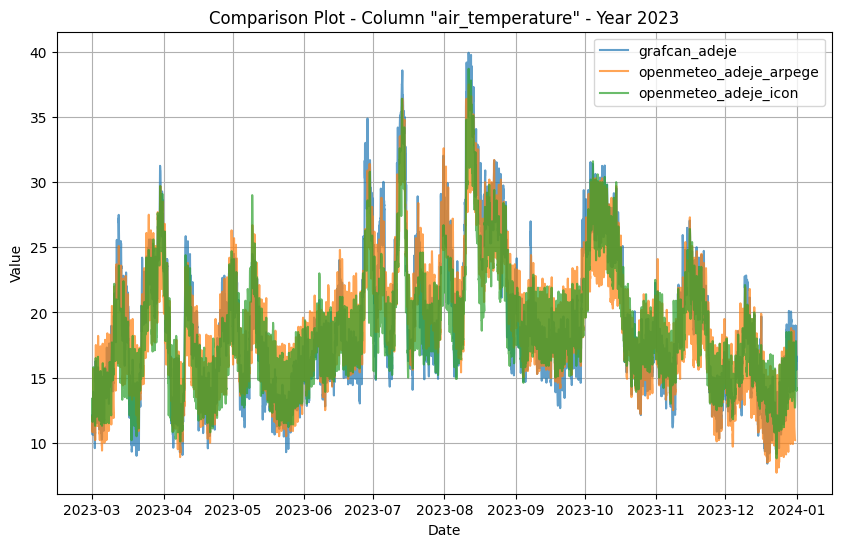

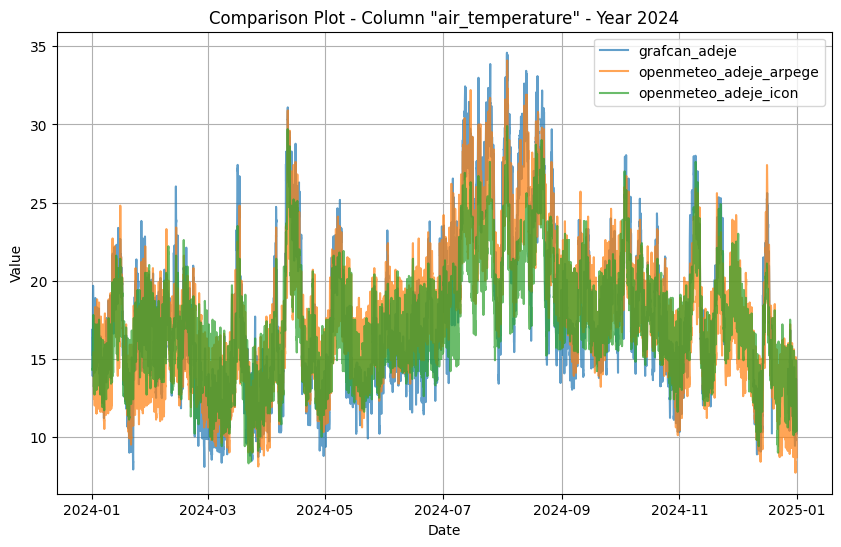

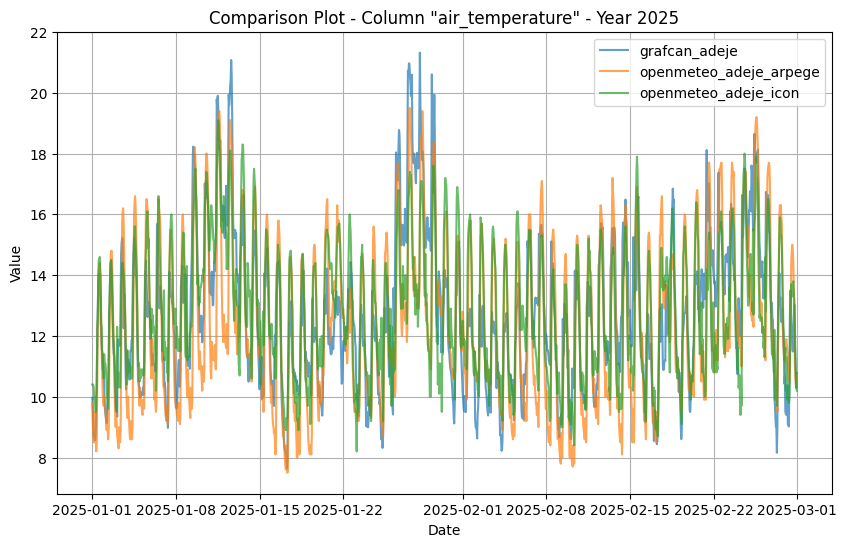

Plotting relative_humidity


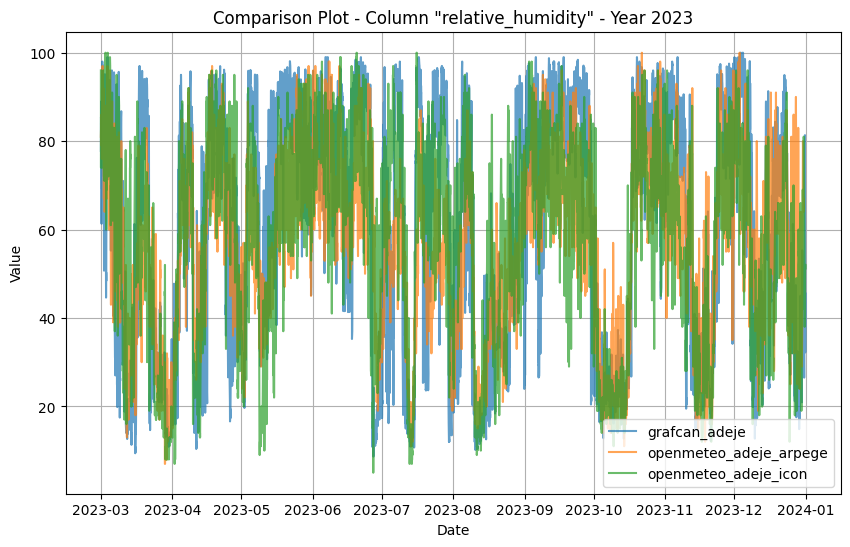

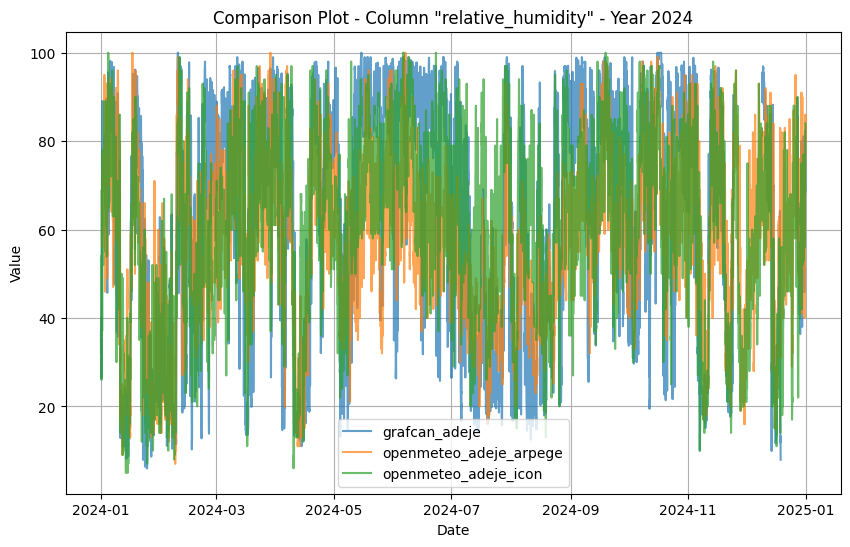

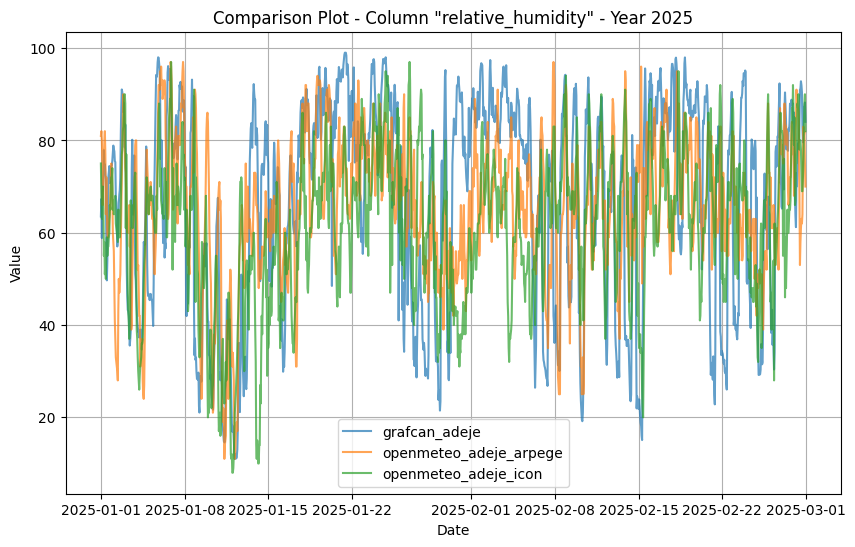

Plotting atmospheric_pressure


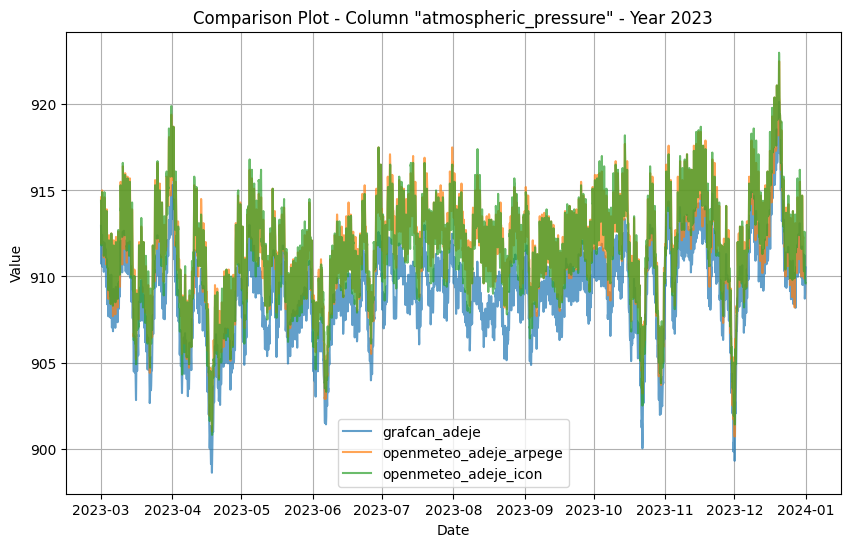

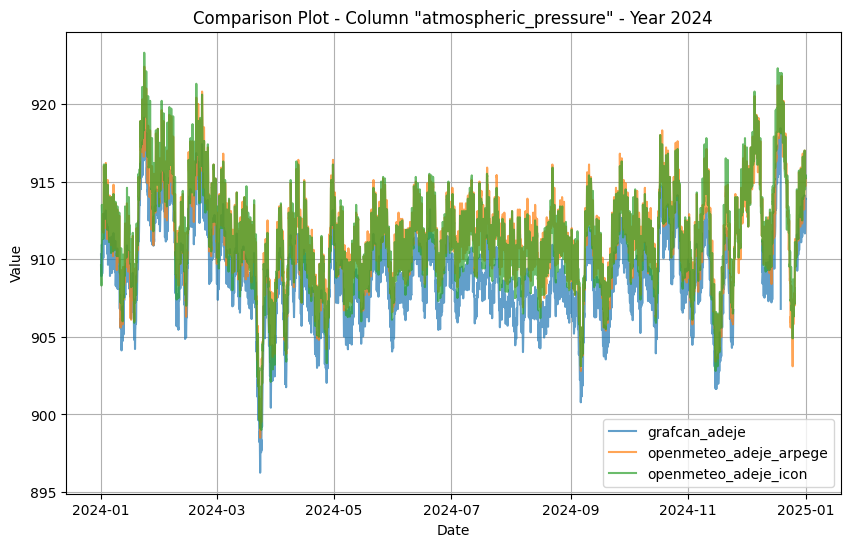

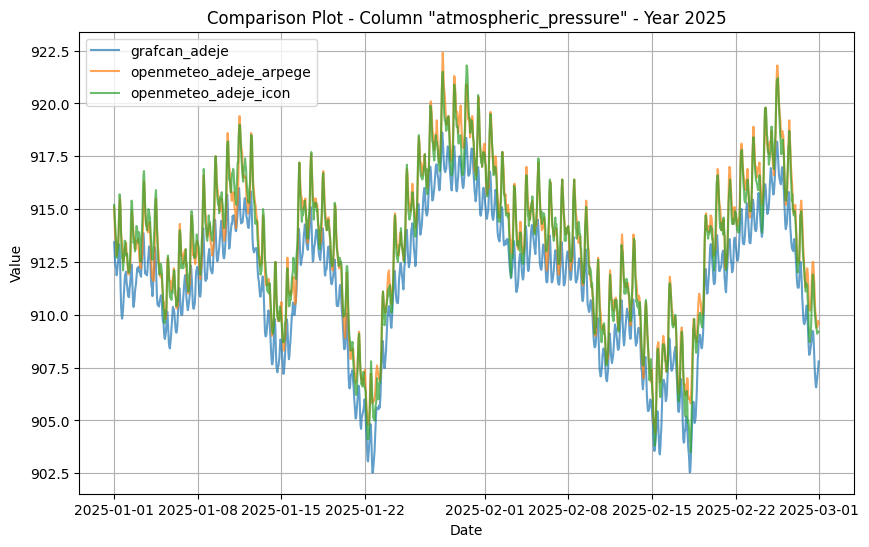

In [5]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [6]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_adeje after resampling:
[Timestamp('2024-04-08 15:00:00+0000', tz='UTC'), Timestamp('2024-11-24 12:00:00+0000', tz='UTC'), Timestamp('2024-11-24 13:00:00+0000', tz='UTC'), Timestamp('2024-11-24 14:00:00+0000', tz='UTC'), Timestamp('2024-11-24 15:00:00+0000', tz='UTC'), Timestamp('2024-11-24 16:00:00+0000', tz='UTC'), Timestamp('2024-11-24 17:00:00+0000', tz='UTC'), Timestamp('2024-11-24 18:00:00+0000', tz='UTC'), Timestamp('2024-11-24 19:00:00+0000', tz='UTC'), Timestamp('2024-11-24 20:00:00+0000', tz='UTC'), Timestamp('2024-11-24 21:00:00+0000', tz='UTC'), Timestamp('2024-11-24 22:00:00+0000', tz='UTC'), Timestamp('2024-11-24 23:00:00+0000', tz='UTC'), Timestamp('2024-11-25 00:00:00+0000', tz='UTC'), Timestamp('2024-11-25 01:00:00+0000', tz='UTC'), Timestamp('2024-11-25 02:00:00+0000', tz='UTC'), Timestamp('2024-11-25 03:00:00+0000', tz='UTC'), Timestamp('2024-11-25 04:00:00+0000', tz='UTC'), Timestamp('2024-11-25 05:00:00+0000', tz='UTC'), Timestamp('2024-11-

### Manejo Horas faltantes

In [7]:
# Pchip Interpolation Algorithm
def pchip_interpolation(df):
    # Ensure index is datetime and convert to numeric (Unix timestamp in seconds)
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value column with zeros if not present
    if "artificial_value" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value":
            continue  # Skip flag column

        valid_mask = ~df[col].isna()

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            # Mark artificially generated values before filling
            nan_mask = df[col].isna()
            df.loc[nan_mask, col] = interpolated_values[nan_mask]
            df.loc[nan_mask, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

#cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')

In [8]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    pchip_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [9]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [10]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_adeje_icon vs grafcan_adeje
  air_temperature:
    Pearson: 0.8924
    Spearman: 0.8793
    Kendall: 0.7031
    MSE: 6.7731
    Euclidean Distance: 344.7135
  atmospheric_pressure:
    Pearson: 0.9076
    Spearman: 0.8895
    Kendall: 0.7432
    MSE: 8.7832
    Euclidean Distance: 392.5460
  relative_humidity:
    Pearson: 0.6563
    Spearman: 0.6158
    Kendall: 0.4424
    MSE: 453.5720
    Euclidean Distance: 2820.8983


In [11]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_adeje_arpege vs grafcan_adeje
  air_temperature:
    Pearson: 0.8946
    Spearman: 0.8747
    Kendall: 0.6990
    MSE: 6.0054
    Euclidean Distance: 324.5908
  atmospheric_pressure:
    Pearson: 0.8970
    Spearman: 0.8775
    Kendall: 0.7227
    MSE: 9.2717
    Euclidean Distance: 403.3144
  relative_humidity:
    Pearson: 0.6387
    Spearman: 0.5978
    Kendall: 0.4234
    MSE: 475.6878
    Euclidean Distance: 2888.8520


### Selección de datasets

In [12]:
ned_df_openmeteo = "openmeteo_" + location
dataframes[ned_df_openmeteo] = dataframes[openmeteo_icon].copy()
dataframes[ned_df_openmeteo]["atmospheric_pressure"] = dataframes[openmeteo_arpege]["atmospheric_pressure"].copy()
dataframes[ned_df_openmeteo]["artificial_value_flag"] += dataframes[openmeteo_arpege]["artificial_value_flag"]

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [13]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_adeje:


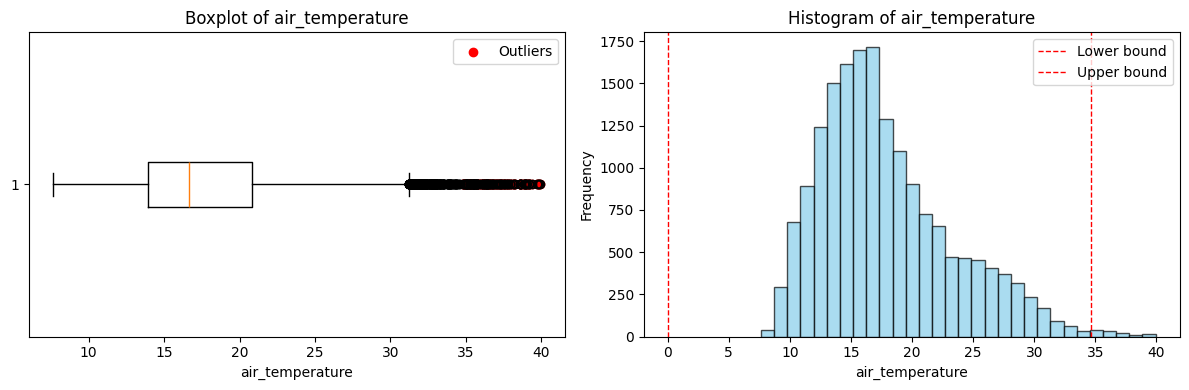

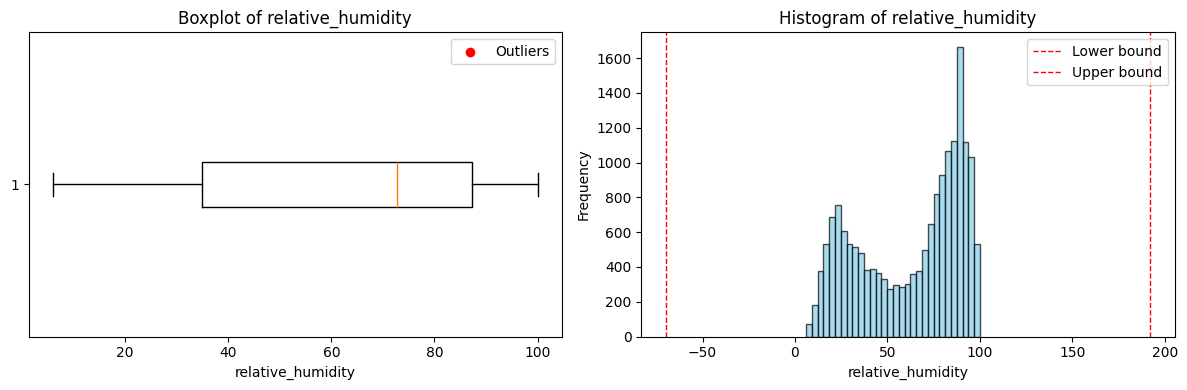

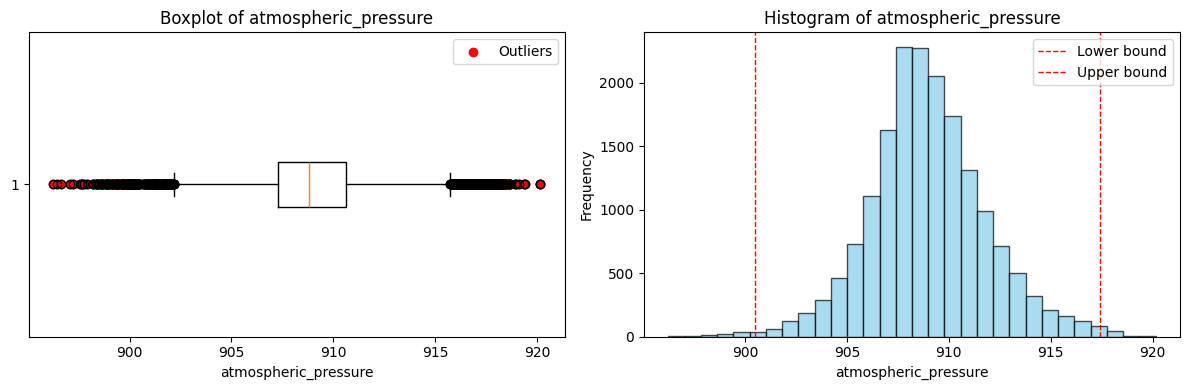

  air_temperature outlier row indices: [Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-07-12 16:00:00+0000', tz='UTC'), Timestamp('2023-07-12 17:00:00+0000', tz='UTC'), Timestamp('2023-07-12 18:00:00+0000', tz='UTC'), Timestamp('2023-07-12 19:00:00+0000', tz='UTC'), Timestamp('2023-07-13 00:00:00+0000', tz='UTC'), Timestamp('2023-07-13 01:00:00+0000', tz='UTC'), Timestamp('2023-07-13 02:00:00+0000', tz='UTC'), Timestamp('2023-07-13 03:00:00+0000', tz='UTC'), Timestamp('2023-07-13 04:00:00+0000', tz='UTC'), Timestamp('2023-07-13 05:00:00+0000', tz='UTC'), Timestamp('2023-07-13 06:00:00+0000', tz='UTC'), Timestamp('2023-07-13 07:00:00+0000', tz='UTC'), Timestamp('2023-07-13 08:00:00+0000', tz='UTC'), Timestamp('2023-07-13 09:00:00+0000', tz='UTC'), Timestamp('2023-07-13 10:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:0

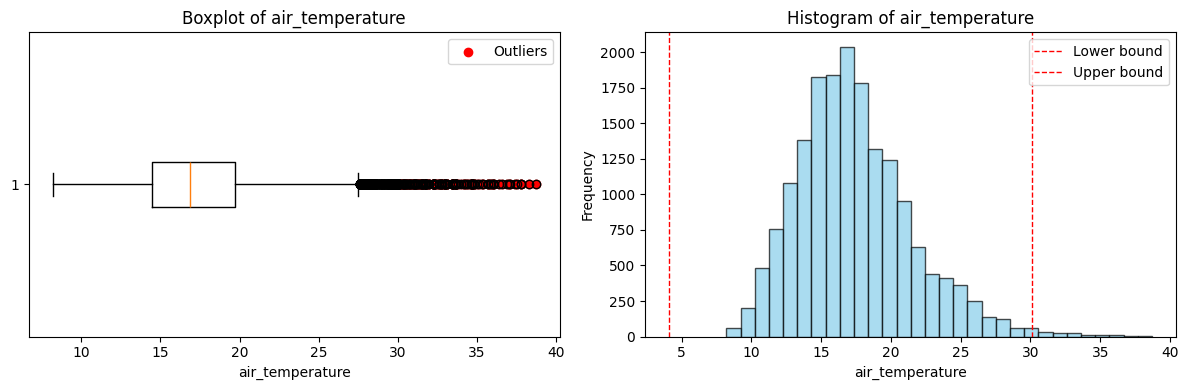

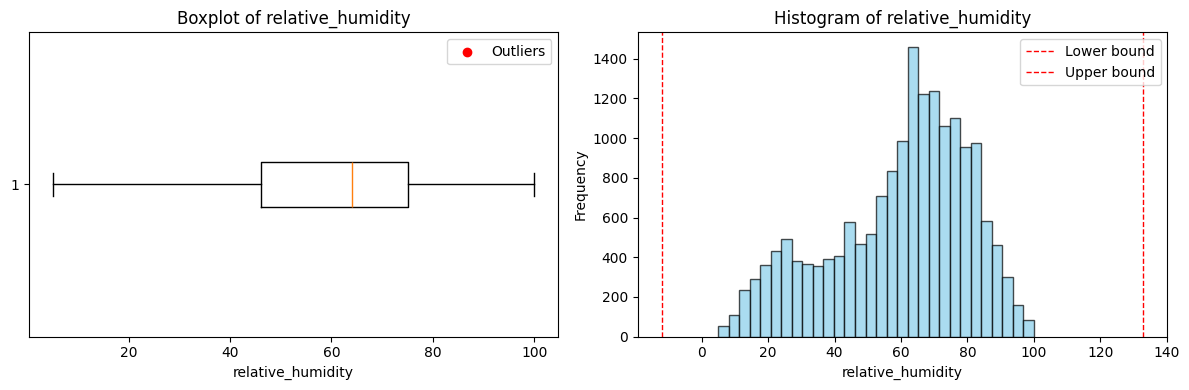

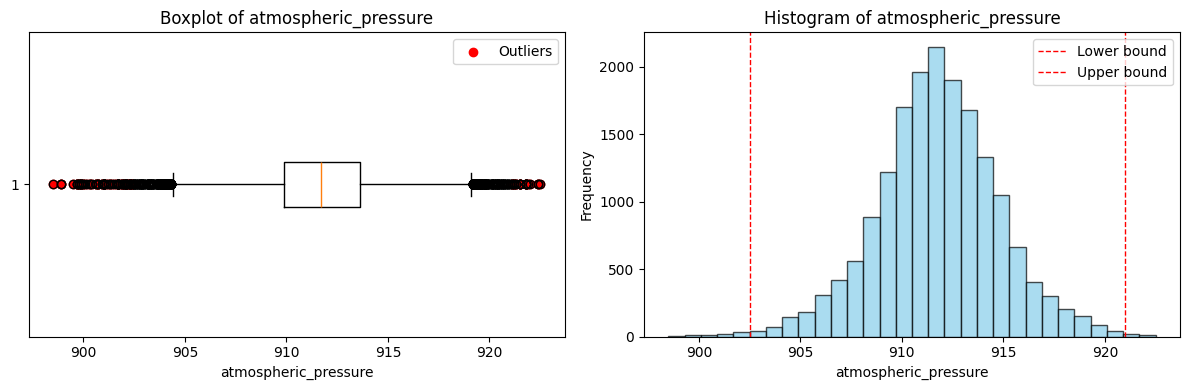

  air_temperature outlier row indices: [Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-07-12 10:00:00+0000', tz='UTC'), Timestamp('2023-07-12 11:00:00+0000', tz='UTC'), Timestamp('2023-07-12 12:00:00+0000', tz='UTC'), Timestamp('2023-07-12 13:00:00+0000', tz='UTC'), Timestamp('2023-07-12 14:00:00+0000', tz='UTC'), Timestamp('2023-07-12 15:00:00+0000', tz='UTC'), Timestamp('2023-07-12 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 09:00:00+0000', tz='UTC'), Timestamp('2023-07-13 10:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 17:00:00+0000', tz='UTC'), Timestamp('2023-07-13 18:00:0

In [14]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_adeje for KNN outlier detection...
air_temperature


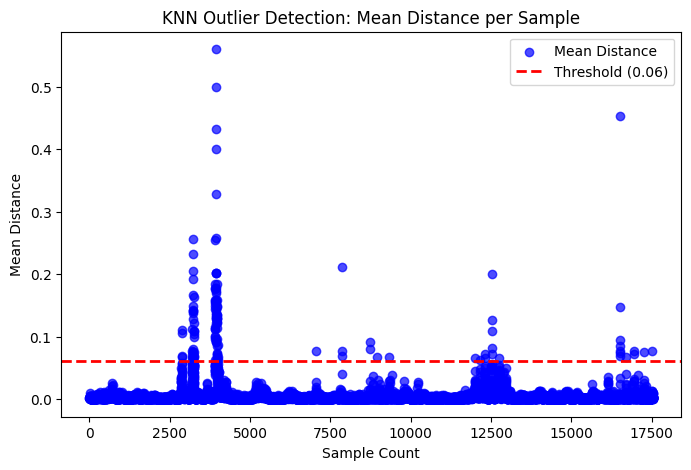

Detected 130 outliers at indices: [ 2868  2869  2870  2871  3186  3194  3206  3207  3208  3212  3215  3217
  3222  3224  3225  3226  3227  3228  3229  3230  3231  3232  3233  3234
  3235  3237  3238  3239  3241  3243  3247  3249  3251  3252  3253  3254
  3897  3898  3899  3900  3901  3902  3903  3904  3905  3906  3907  3908
  3909  3914  3921  3922  3923  3924  3925  3926  3927  3928  3929  3930
  3931  3932  3933  3935  3936  3938  3944  3945  3946  3947  3948  3949
  3950  3951  3952  3953  3954  3955  3958  3960  3962  3963  3965  3967
  3968  3969  3970  3971  3972  3973  3974  3975  3976  3977  3978  3979
  3981  3993  3998  4002  7037  7854  7855  7856  8742  8743  8959  9338
 11994 12159 12305 12306 12514 12515 12520 12522 12523 12755 16514 16515
 16516 16517 16518 16519 16520 16711 16950 16951 17262 17503]
atmospheric_pressure


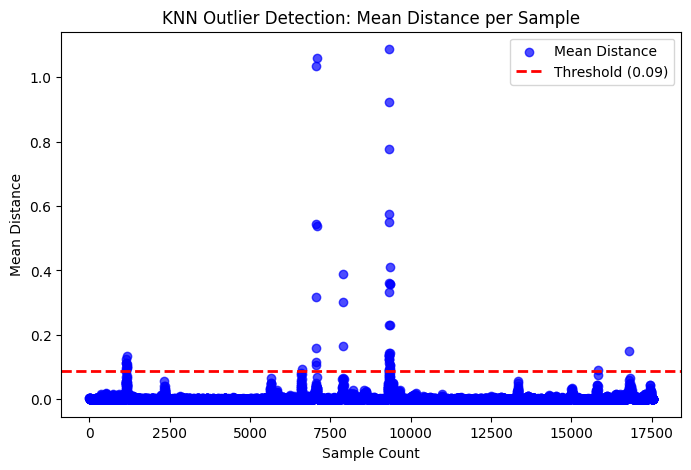

Detected 52 outliers at indices: [ 1135  1136  1146  1147  1148  1154  1155  1156  1157  1158  6604  7042
  7043  7063  7064  7065  7066  7067  7068  7882  7883  7884  9316  9317
  9318  9319  9320  9321  9322  9323  9324  9325  9326  9327  9328  9329
  9330  9331  9332  9337  9338  9339  9340  9341  9342  9343  9344  9345
  9352  9355 15815 16787]
relative_humidity


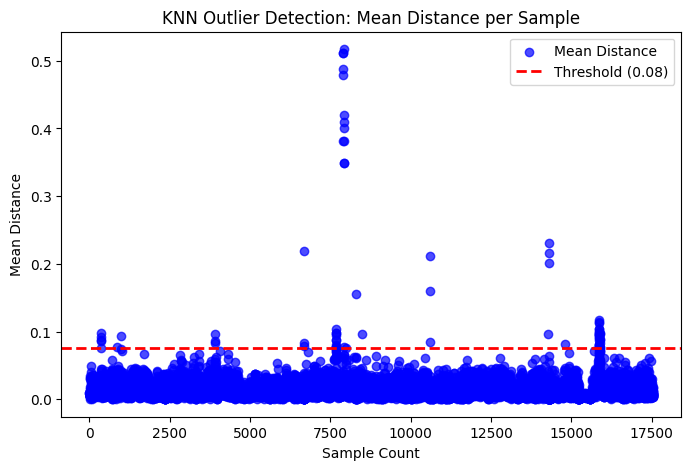

Detected 74 outliers at indices: [  356   357   358   359   361   871   996  3902  3903  3921  6663  6664
  6686  7659  7660  7664  7666  7667  7668  7679  7680  7681  7685  7894
  7895  7896  7897  7898  7914  7915  7916  7917  7918  7919  7920  7921
  7971  8302  8478 10590 10591 10593 14279 14293 14294 14300 14811 15849
 15850 15851 15852 15853 15854 15858 15859 15860 15861 15864 15865 15866
 15867 15868 15869 15870 15871 15872 15873 15874 15875 15877 15878 15879
 15880 15883]
Processing openmeteo_adeje for KNN outlier detection...
air_temperature


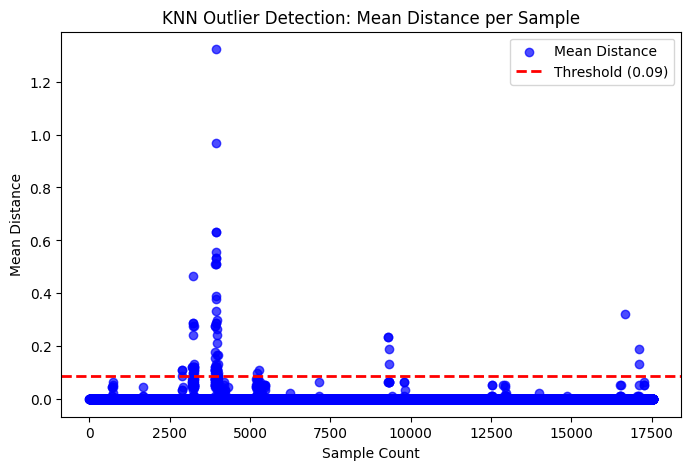

Detected 85 outliers at indices: [ 2892  2893  2894  3205  3206  3208  3225  3226  3228  3229  3230  3231
  3232  3233  3240  3241  3243  3245  3253  3254  3256  3258  3900  3901
  3902  3903  3904  3905  3915  3916  3918  3920  3921  3922  3923  3924
  3925  3926  3927  3928  3929  3932  3934  3936  3937  3938  3939  3940
  3942  3945  3946  3947  3948  3949  3950  3951  3952  3953  3955  3956
  3957  3958  3959  3960  3963  3965  3969  3972  3973  3975  3978  3993
  3994  3997  3998  4000  5222  5269  9294  9295  9316  9318 16659 17095
 17096]
atmospheric_pressure


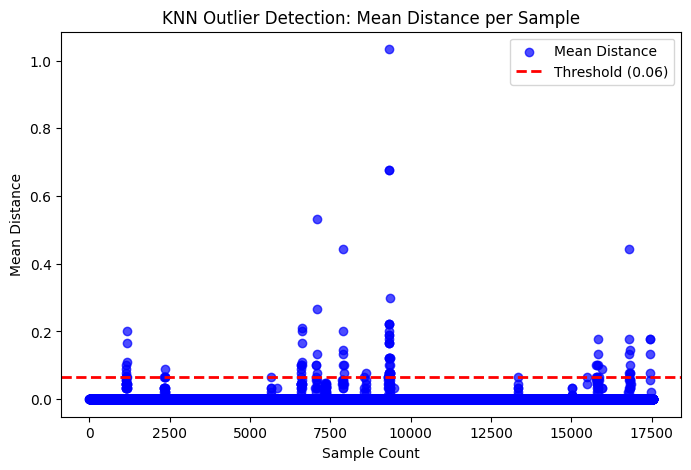

Detected 105 outliers at indices: [ 1130  1132  1133  1134  1135  1144  1150  1151  1154  1155  1158  1161
  2333  2336  2341  2342  2344  5643  6592  6594  6596  6598  6599  6602
  6603  6604  6605  6606  7043  7044  7066  7067  7068  7069  7070  7883
  7884  7885  7886  7887  7907  7908  8556  8604  9294  9304  9305  9309
  9313  9314  9315  9316  9317  9318  9319  9320  9321  9322  9323  9325
  9326  9327  9328  9329  9330  9331  9332  9333  9337  9338  9339  9340
  9341  9342  9343  9344  9346  9347  9352  9354 13327 15492 15779 15780
 15782 15803 15804 15827 15828 15829 15851 15966 16787 16788 16789 16790
 16793 16811 16812 16835 16836 17459 17460 17461 17462]
relative_humidity


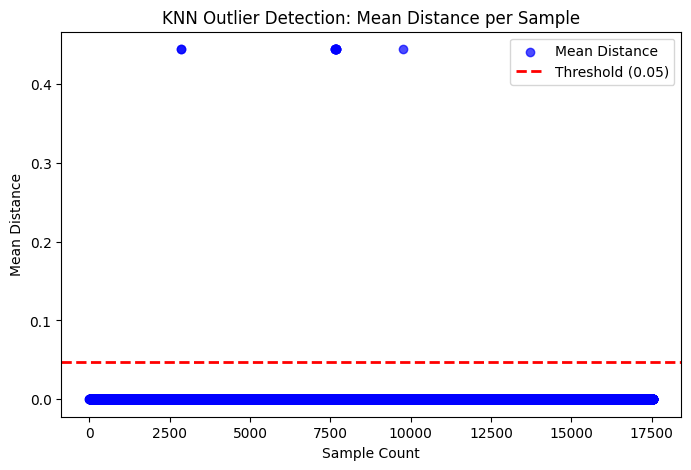

Detected 12 outliers at indices: [2838 2839 7654 7655 7656 7657 7658 7662 7663 7664 7680 9745]


In [15]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_adeje...


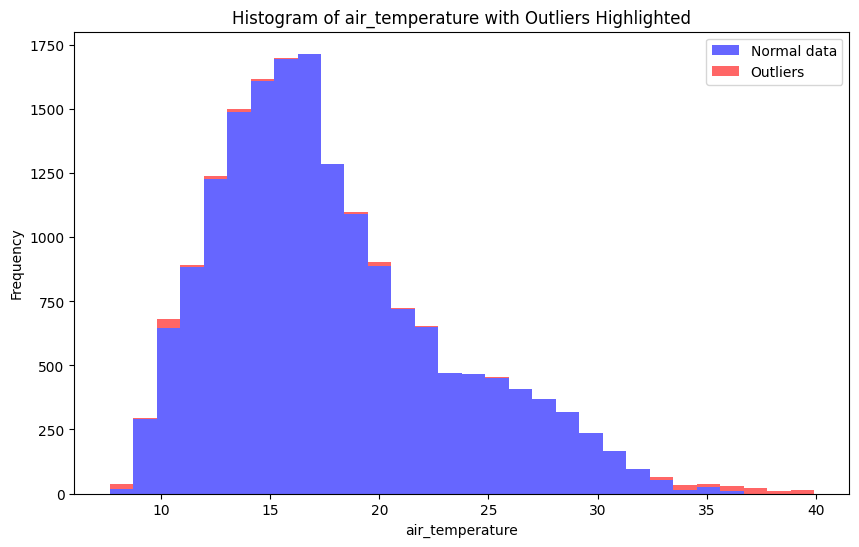

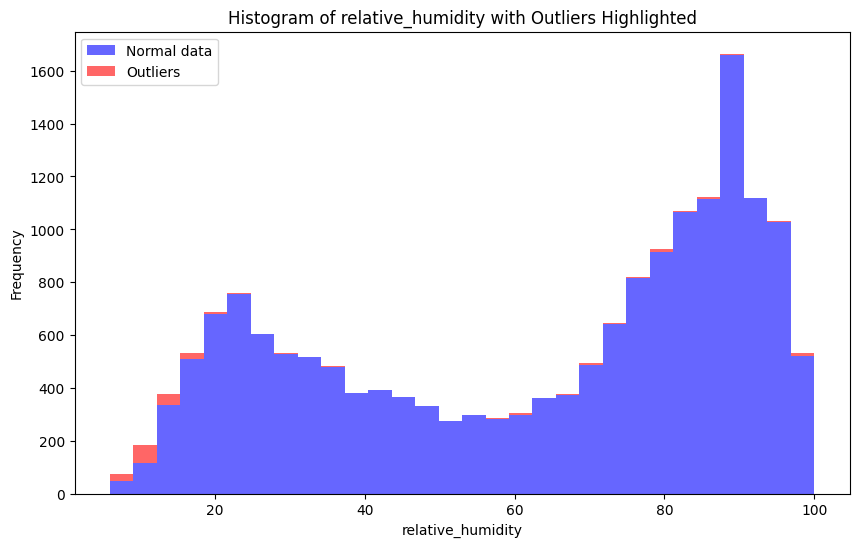

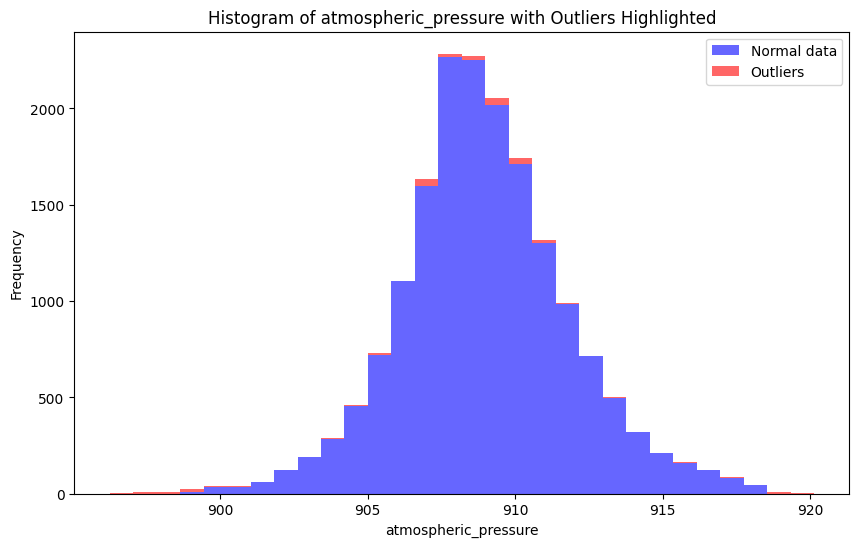

Plotting histogram for openmeteo_adeje...


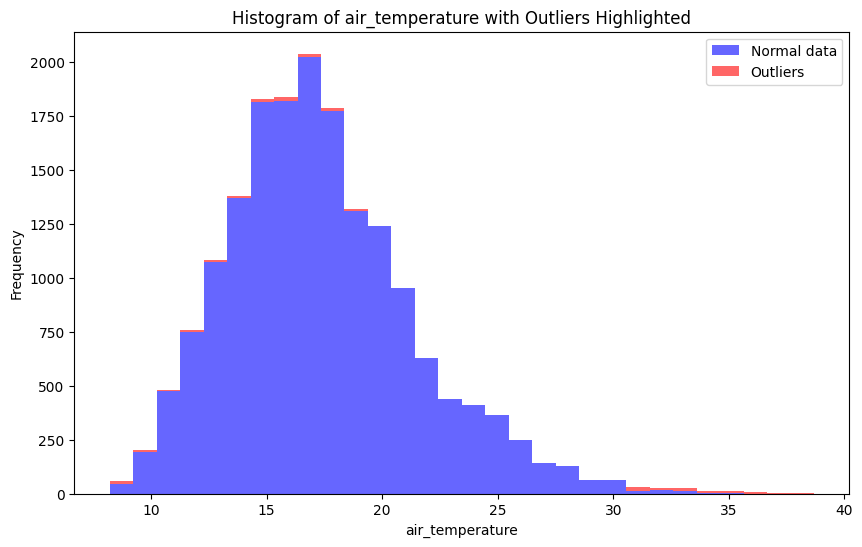

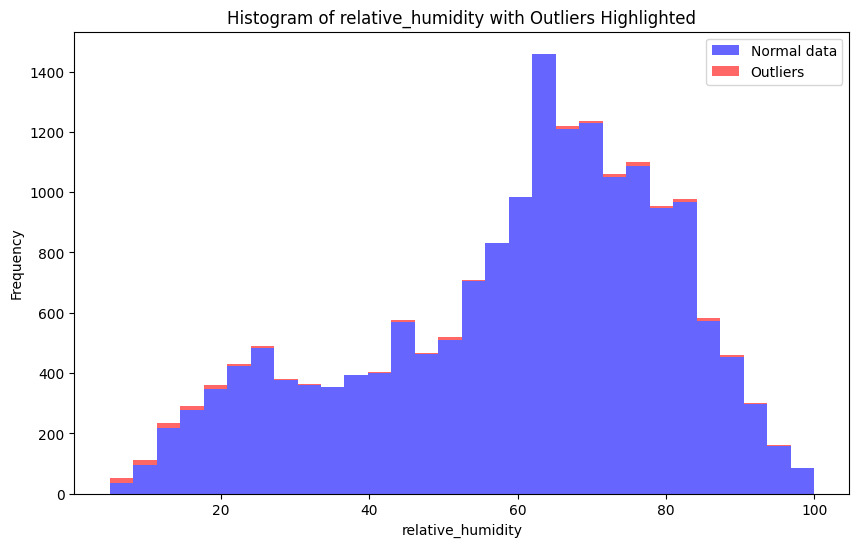

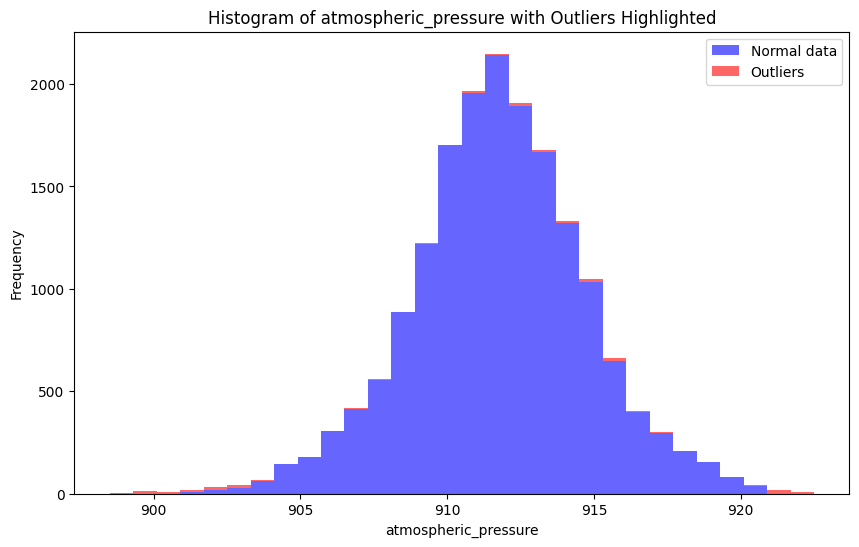

In [16]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [17]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_adeje...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12271.4526
Frequency: 0.00000013 Hz, Period: 2193.00 hours, Magnitude: 12957.1866
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 13653.9470
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 15513.6195
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 35330.1114


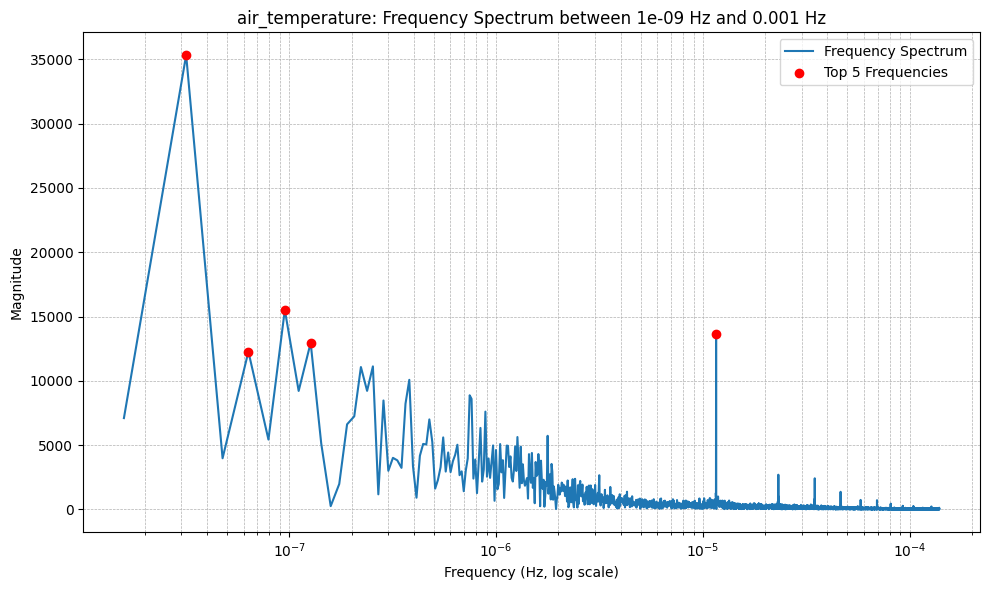

Top 5 frequencies with highest magnitude:
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 68936.0343
Frequency: 0.00000025 Hz, Period: 1096.50 hours, Magnitude: 69057.1012
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 69928.2013
Frequency: 0.00000028 Hz, Period: 974.67 hours, Magnitude: 70734.6050
Frequency: 0.00000013 Hz, Period: 2193.00 hours, Magnitude: 76011.5296


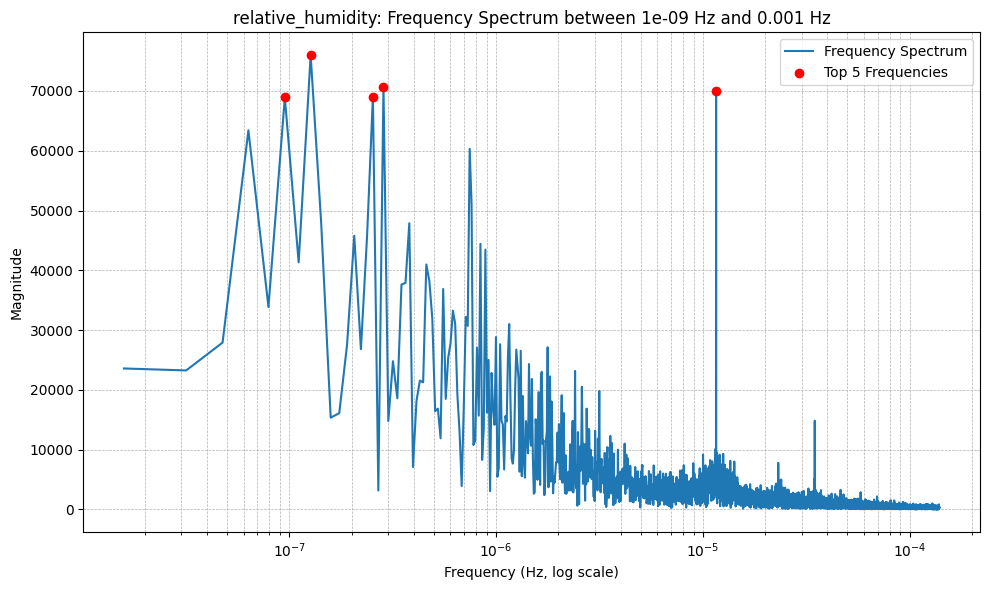

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 6491.0769
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 6845.2205
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 7420.7696
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 9627.8968
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 12186.9814


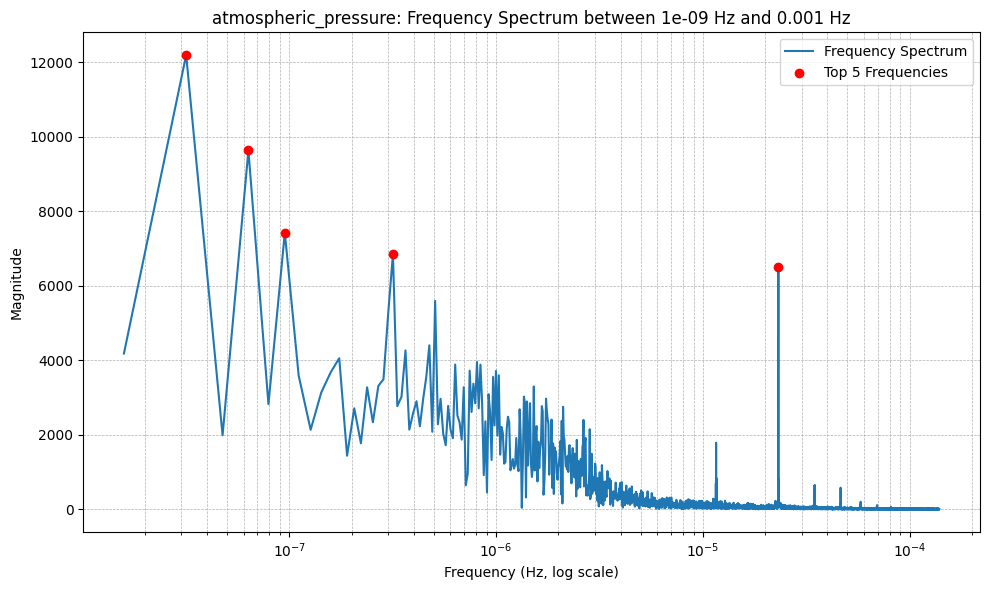

Plotting frequencies for openmeteo_adeje...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 7685.9103
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 7720.5976
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 7980.4366
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 18826.7050
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 29361.1165


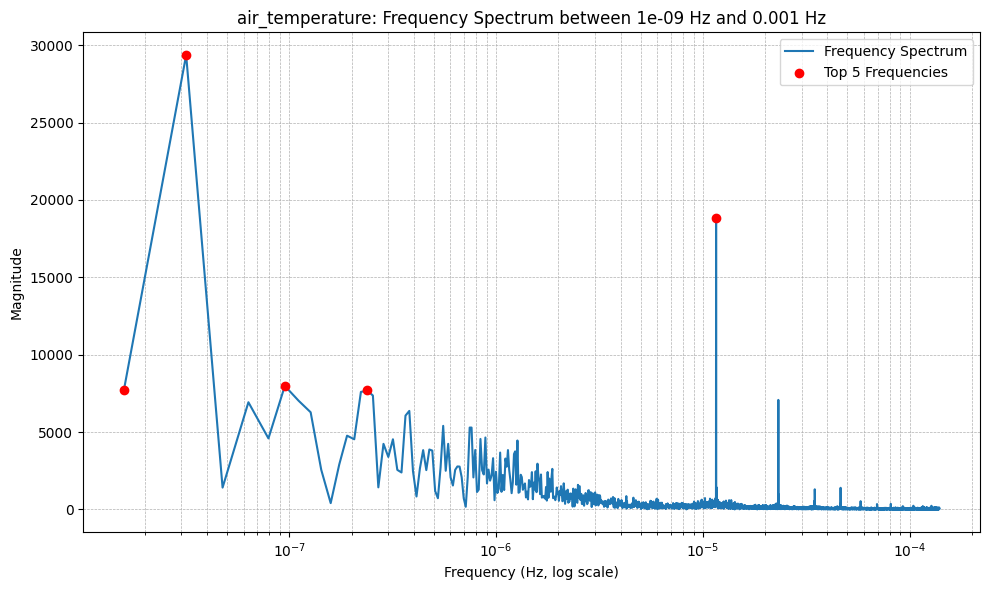

Top 5 frequencies with highest magnitude:
Frequency: 0.00000025 Hz, Period: 1096.50 hours, Magnitude: 39197.2986
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 39551.4685
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 39787.8523
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 54018.9741
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 55130.9087


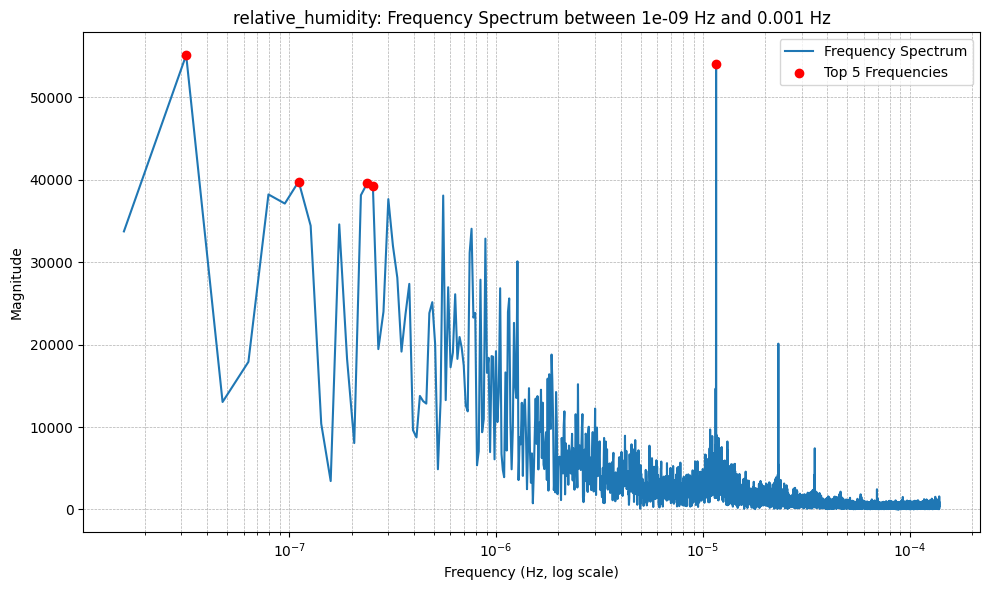

Top 5 frequencies with highest magnitude:
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 6565.6219
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7544.5544
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 8861.7786
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 9486.2046
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 9984.9633


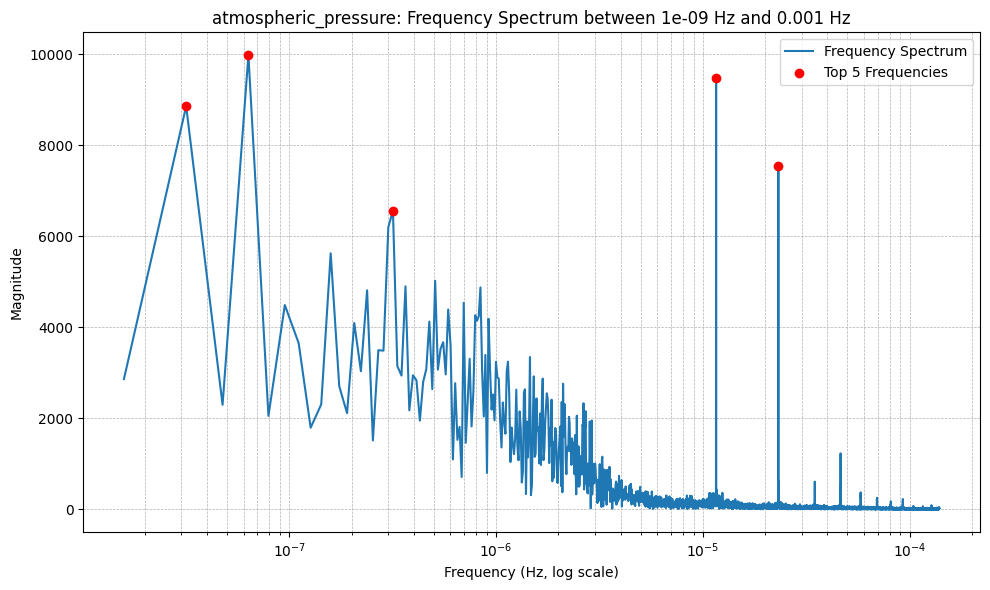

In [18]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [19]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_adeje...


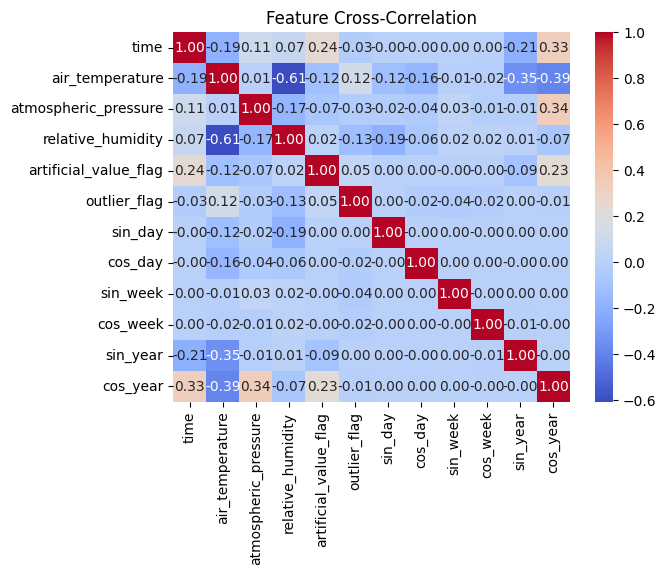

Plotting correlations for openmeteo_adeje...


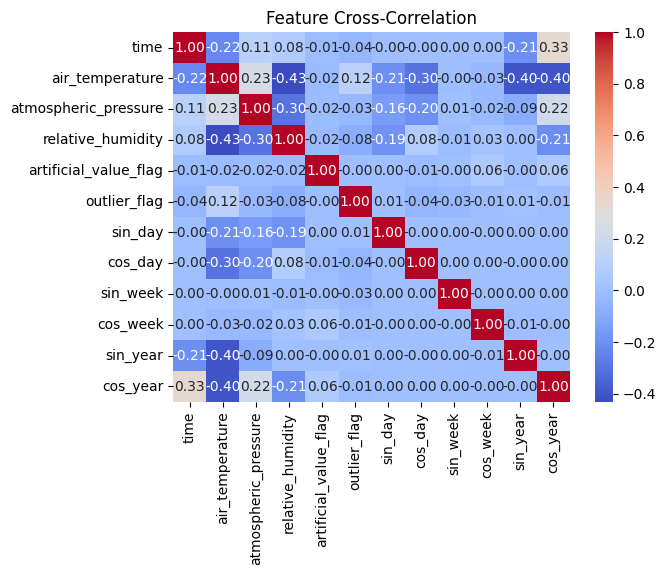

In [20]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [21]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [22]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)